Loading DL models...
DL models loaded.
Loading test data for DL models...
Predicting with DL models...
4720/4720 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step
4720/4720 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step
4720/4720 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step
4720/4720 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


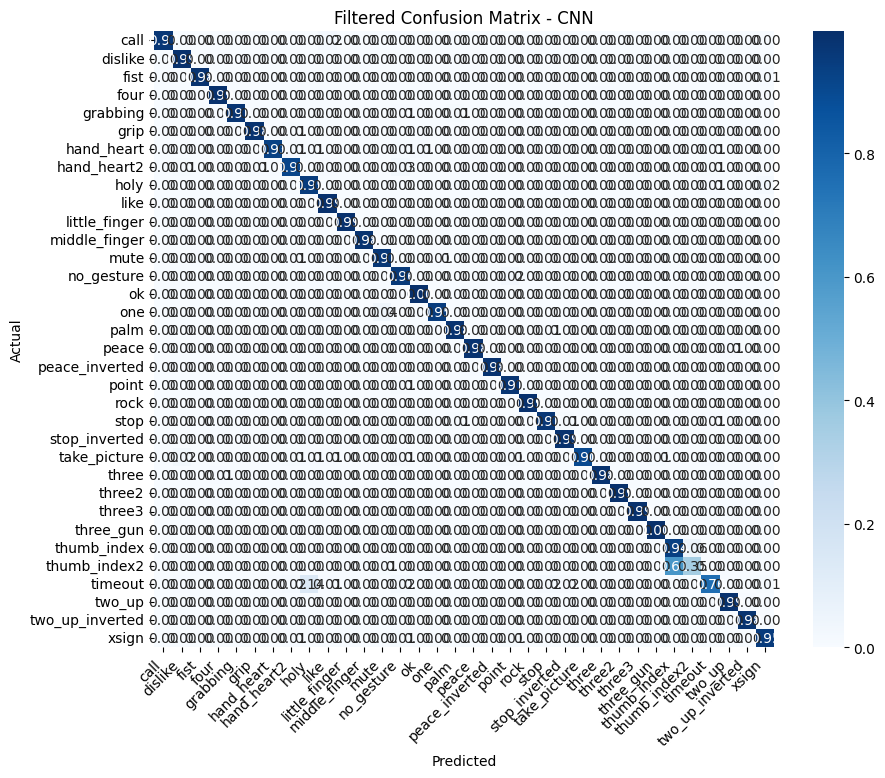

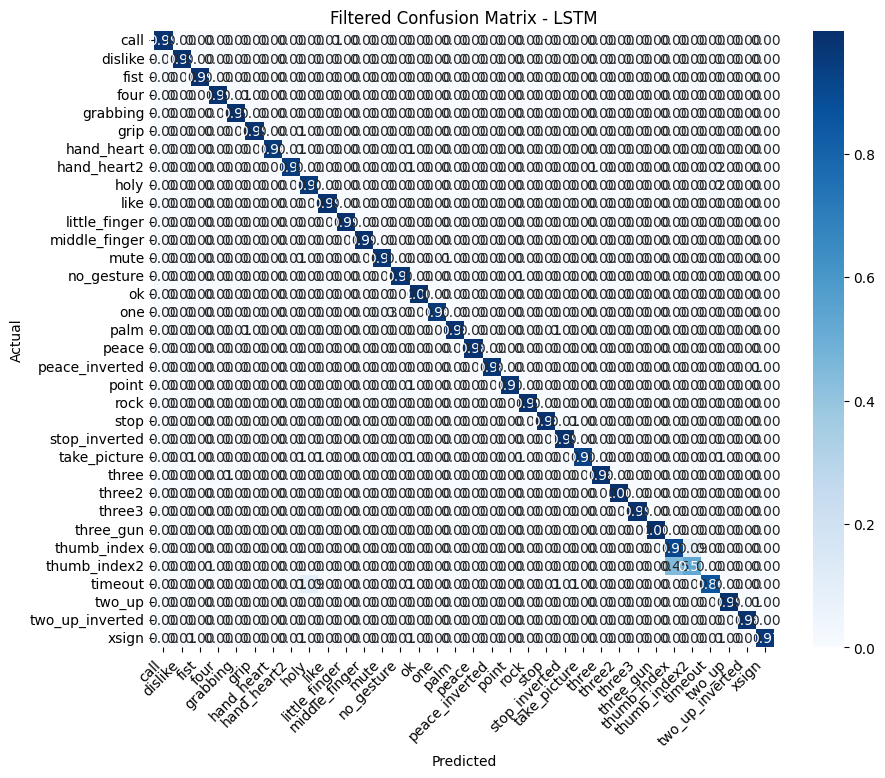

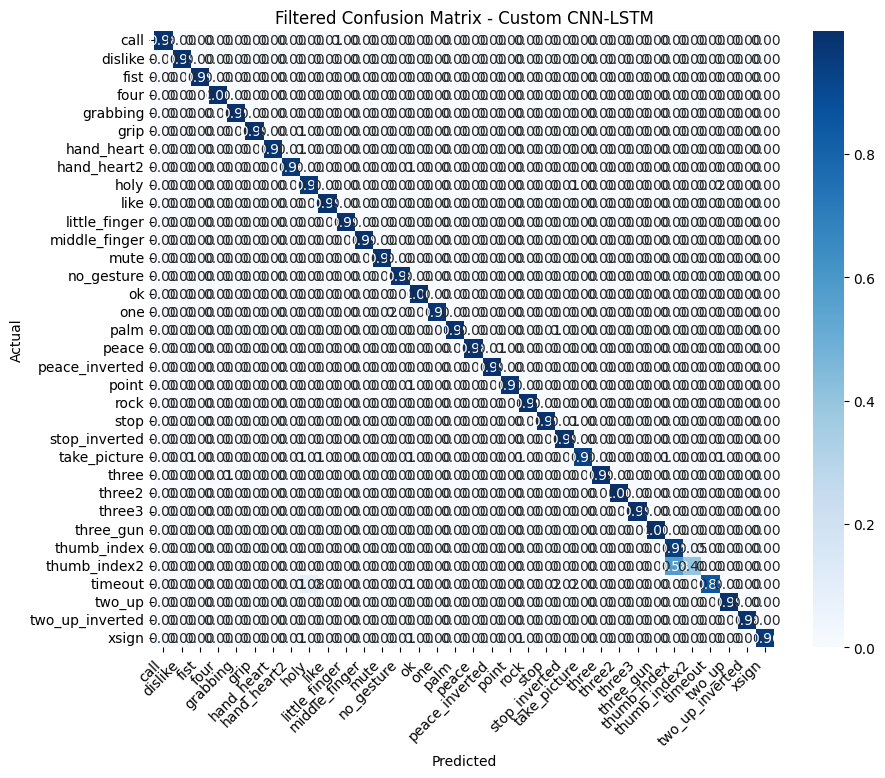

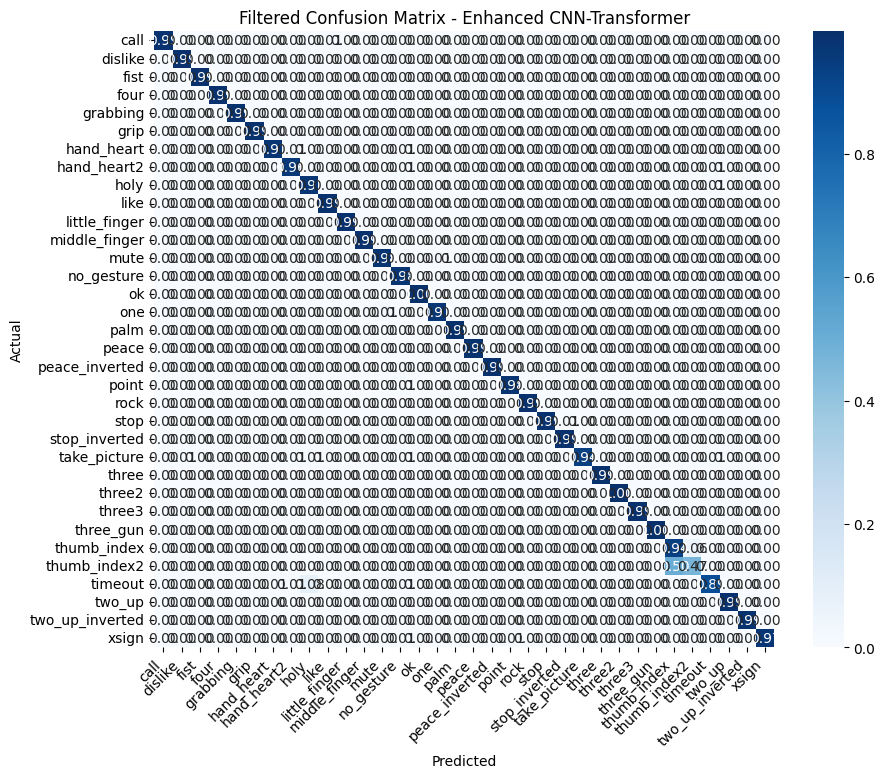


Detailed Performance Reports:

Classification Report for CNN:
                 precision    recall  f1-score   support

           call       0.99      0.97      0.98      4494
        dislike       0.96      0.99      0.98      4489
           fist       0.98      0.98      0.98      4481
           four       0.99      0.99      0.99      4527
       grabbing       0.99      0.97      0.98      4359
           grip       0.98      0.98      0.98      4191
     hand_heart       0.98      0.93      0.96      4501
    hand_heart2       0.90      0.92      0.91      2705
           holy       0.84      0.95      0.89      2979
           like       0.95      0.99      0.97      4446
  little_finger       0.99      0.99      0.99      4404
  middle_finger       0.99      0.98      0.99      4350
           mute       0.94      0.97      0.95      4542
     no_gesture       0.96      0.96      0.96     11037
             ok       0.98      1.00      0.99      4527
            one       0.

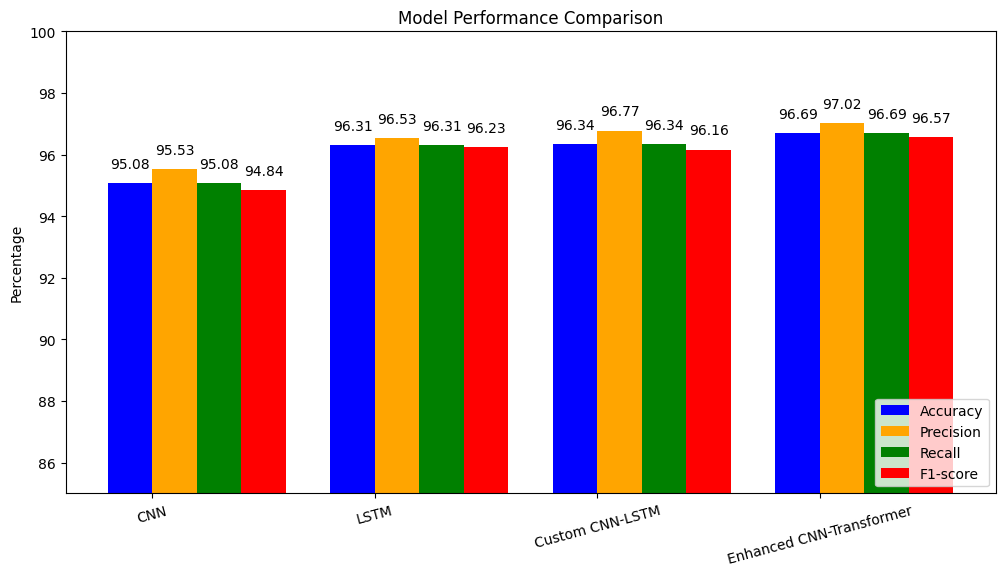

Evaluation complete.


In [19]:
import pandas as pd
import json
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from tensorflow.keras.models import load_model

base_path = "/kaggle/input/"  
save_path = "/kaggle/working/"  

print("Loading DL models...")
cnn = load_model("/kaggle/input/cnn/keras/default/1/cnn_model.keras")
lstm = load_model("/kaggle/input/lstm/keras/default/1/lstm_model.keras")
custom_model = load_model("/kaggle/input/cnn_lstm/keras/default/1/custom_model.keras")
enhanced_model = load_model("/kaggle/input/cnn-t/keras/default/1/enhanced_model.keras")
print("DL models loaded.")

print("Loading test data for DL models...")
with open(base_path + "pjtii-dataset/test.json", "r") as f:
    test_dl_data = json.load(f)

X_test_dl = np.array([entry["hand_landmarks"] for entry in test_dl_data])
y_test_dl = np.array([entry["label"] for entry in test_dl_data])

labels = sorted(set(y_test_dl))
label_to_index = {label: idx for idx, label in enumerate(labels)}
y_test_dl_encoded = np.array([label_to_index[label] for label in y_test_dl])

def measure_dl_inference_time(model, X):
    start_time = time.time()
    predictions = np.argmax(model.predict(X, batch_size=32), axis=1)
    end_time = time.time()
    return predictions, (end_time - start_time) / len(X) * 1000

print("Predicting with DL models...")
pred_cnn, time_cnn = measure_dl_inference_time(cnn, X_test_dl)
pred_lstm, time_lstm = measure_dl_inference_time(lstm, X_test_dl)
pred_custom, time_custom = measure_dl_inference_time(custom_model, X_test_dl)
pred_enhanced, time_enhanced = measure_dl_inference_time(enhanced_model, X_test_dl)

def evaluate_model(y_true, y_pred, model_name, results_dict, inference_time):
    accuracy = accuracy_score(y_true, y_pred) * 100
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=1) * 100
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=1) * 100
    f1 = f1_score(y_true, y_pred, average='weighted') * 100
    results_dict[model_name] = [accuracy, precision, recall, f1, inference_time]

results = {}
evaluate_model(y_test_dl_encoded, pred_cnn, "CNN", results, time_cnn)
evaluate_model(y_test_dl_encoded, pred_lstm, "LSTM", results, time_lstm)
evaluate_model(y_test_dl_encoded, pred_custom, "Custom CNN-LSTM", results, time_custom)
evaluate_model(y_test_dl_encoded, pred_enhanced, "Enhanced CNN-Transformer", results, time_enhanced)

def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred, normalize='true')  # Normalize by row
    misclassified_labels = np.where(cm < 0.9)  # Only show classes with significant misclassification
    filtered_labels = sorted(set(misclassified_labels[0]) | set(misclassified_labels[1]))
    filtered_cm = cm[np.ix_(filtered_labels, filtered_labels)]
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(filtered_cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=[labels[i] for i in filtered_labels], 
                yticklabels=[labels[i] for i in filtered_labels])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Filtered Confusion Matrix - {model_name}")
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.show()

plot_confusion_matrix(y_test_dl_encoded, pred_cnn, "CNN")
plot_confusion_matrix(y_test_dl_encoded, pred_lstm, "LSTM")
plot_confusion_matrix(y_test_dl_encoded, pred_custom, "Custom CNN-LSTM")
plot_confusion_matrix(y_test_dl_encoded, pred_enhanced, "Enhanced CNN-Transformer")

print("\nDetailed Performance Reports:")
for model_name, pred in zip(["CNN", "LSTM", "Custom CNN-LSTM", "Enhanced CNN-Transformer"], 
                            [pred_cnn, pred_lstm, pred_custom, pred_enhanced]):
    print(f"\nClassification Report for {model_name}:")
    print(classification_report(y_test_dl_encoded, pred, target_names=labels))

metrics = ["Accuracy", "Precision", "Recall", "F1-score"]
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(results))
width = 0.2

colors = ['blue', 'orange', 'green', 'red']
for i, metric in enumerate(metrics):
    values = [results[model][i] for model in results]
    ax.bar(x + i * width, values, width, label=metric, color=colors[i])
    for j, v in enumerate(values):
        ax.text(j + i * width, v + 0.5, f"{v:.2f}", ha='center', fontsize=10)

ax.set_ylabel("Percentage")
ax.set_xticks(x + width / 2)
ax.set_xticklabels(results.keys(), rotation=15)
ax.set_title("Model Performance Comparison")
ax.legend(loc='lower right')
ax.set_ylim(85, 100)  # Adjust y-axis for clarity
plt.show()

print("Evaluation complete.")


In [ ]:
import tensorflow as tf
import json
import os
import numpy as np
import joblib
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

base_path = "/kaggle/input"  

with open(os.path.join(base_path, "pjtii-dataset/hagrid_dl_dataset.json"), "r") as f:
    dl_data = json.load(f)

X_dl = np.array([entry["hand_landmarks"] for entry in dl_data])
y_dl = [entry["label"] for entry in dl_data]

label_encoder = joblib.load(os.path.join(base_path, "knn/tensorflow2/default/1/label_encoder.pkl"))
y_dl = label_encoder.transform(y_dl)
y_dl = tf.keras.utils.to_categorical(y_dl)

scaler = StandardScaler()
X_dl = scaler.fit_transform(X_dl.reshape(-1, X_dl.shape[-1])).reshape(X_dl.shape)

X_train_dl, X_val_dl, y_train_dl, y_val_dl = train_test_split(X_dl, y_dl, test_size=0.2, random_state=42, stratify=y_dl)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train_dl.shape[1], X_train_dl.shape[2]), kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Dropout(0.3),  # Dropout to reduce overfitting
    tf.keras.layers.Conv1D(128, kernel_size=3, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(y_dl.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

history = model.fit(X_train_dl, y_train_dl,
                    validation_data=(X_val_dl, y_val_dl),
                    epochs=50,
                    batch_size=32,
                    callbacks=[early_stopping])

model.save("cnn_2_model.keras")

history_path = "cnn_2_training_history.json"
with open(history_path, "w") as f:
    json.dump(history.history, f)

print("Training complete. CNN model and history saved successfully!")


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LabelEncoder from version 1.6.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Evaluating CNN model on test dataset...
4720/4720 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.1322 - loss: 3.1303
CNN Model Test Accuracy: 9.21%
CNN Model Test Loss: 3.5343


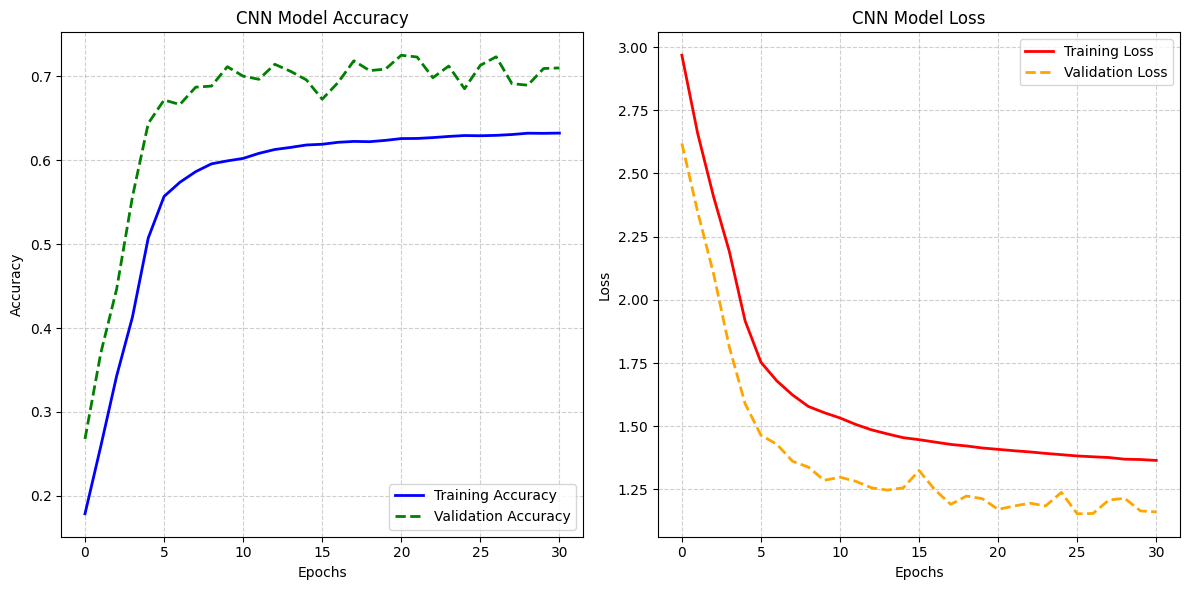

4720/4720 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step
CNN Model Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.16      0.38      0.22      4494
           1       0.81      0.17      0.28      4489
           2       0.11      0.12      0.11      4481
           3       0.29      0.15      0.19      4527
           4       0.00      0.00      0.00      4359
           5       0.64      0.00      0.00      4191
           6       0.75      0.00      0.00      4501
           7       0.03      0.43      0.06      2705
           8       0.10      0.40      0.16      2979
           9       0.00      0.00      0.00      4446
          10       0.00      0.00      0.00      4404
          11       0.99      0.04      0.08      4350
          12       0.08      0.23      0.12      4542
          13       0.32      0.12      0.18     11037
          14       0.92      0.13      0.23      4527
          15       0.88      0.02      0.04    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [22]:
import matplotlib.pyplot as plt
import tensorflow as tf
import json
import os
import numpy as np
import joblib
from sklearn.metrics import accuracy_score, classification_report

base_path = "/kaggle/input"  # Change to your dataset path

with open(os.path.join(base_path, "pjtii-dataset/test.json"), "r") as f:
    test_dl_data = json.load(f)

X_test_dl = np.array([entry["hand_landmarks"] for entry in test_dl_data])
y_test_dl = [entry["label"] for entry in test_dl_data]

label_encoder = joblib.load(os.path.join(base_path, "knn/tensorflow2/default/1/label_encoder.pkl"))
y_test_dl = label_encoder.transform(y_test_dl)
y_test_dl = tf.keras.utils.to_categorical(y_test_dl)

model = tf.keras.models.load_model("/kaggle/working/cnn_2_model.keras")

print("Evaluating CNN model on test dataset...")
loss_test, accuracy_test = model.evaluate(X_test_dl, y_test_dl)
print(f"CNN Model Test Accuracy: {accuracy_test * 100:.2f}%")
print(f"CNN Model Test Loss: {loss_test:.4f}")

history_path = "/kaggle/working/cnn_2_training_history.json"
with open(history_path, "r") as f:
    history = json.load(f)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history["accuracy"], label="Training Accuracy", color="blue", linewidth=2)
plt.plot(history["val_accuracy"], label="Validation Accuracy", color="green", linestyle="--", linewidth=2)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("CNN Model Accuracy")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)

plt.subplot(1, 2, 2)
plt.plot(history["loss"], label="Training Loss", color="red", linewidth=2)
plt.plot(history["val_loss"], label="Validation Loss", color="orange", linestyle="--", linewidth=2)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("CNN Model Loss")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()

y_pred_dl_test = np.argmax(model.predict(X_test_dl), axis=1)
y_true_dl_test = np.argmax(y_test_dl, axis=1)

print("CNN Model Classification Report (Test Data):")
print(classification_report(y_true_dl_test, y_pred_dl_test))


In [1]:
import tensorflow as tf
import json
import os
import numpy as np
import joblib
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Set base path for dataset
base_path = "/kaggle/input"  # Change to your dataset path

# Load dataset
with open(os.path.join(base_path, "pjtii-dataset/hagrid_dl_dataset.json"), "r") as f:
    dl_data = json.load(f)

X_dl = np.array([entry["hand_landmarks"] for entry in dl_data])
y_dl = [entry["label"] for entry in dl_data]

# Load label encoder
label_encoder = joblib.load(os.path.join(base_path, "knn/tensorflow2/default/1/label_encoder.pkl"))
y_dl = label_encoder.transform(y_dl)
y_dl = tf.keras.utils.to_categorical(y_dl)

# Normalize Data
scaler = StandardScaler()
X_dl = scaler.fit_transform(X_dl.reshape(-1, X_dl.shape[-1])).reshape(X_dl.shape)

# Split dataset
X_train_dl, X_val_dl, y_train_dl, y_val_dl = train_test_split(X_dl, y_dl, test_size=0.2, random_state=42, stratify=y_dl)

# Define CNN-LSTM Model
model = tf.keras.models.Sequential([
    # CNN Feature Extraction
    tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train_dl.shape[1], X_train_dl.shape[2]), kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Dropout(0.3),  # Dropout to reduce overfitting
    tf.keras.layers.Conv1D(128, kernel_size=3, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),

    # LSTM for Temporal Processing
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64),

    # Fully Connected Layers
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(y_dl.shape[1], activation='softmax')
])

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Early Stopping Callback
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train_dl, y_train_dl,
                    validation_data=(X_val_dl, y_val_dl),
                    epochs=50,
                    batch_size=32,
                    callbacks=[early_stopping])

# Save model
model.save("cnn_lstm_2_model.keras")

# Save training history
history_path = "cnn_lstm_2_training_history.json"
with open(history_path, "w") as f:
    json.dump(history.history, f)

print("Training complete. CNN-LSTM model and history saved successfully!")

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LabelEncoder from version 1.6.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
18581/18581 ━━━━━━━━━━━━━━━━━━━━ 138s 7ms/step - accuracy: 0.5165 - loss: 1.7451 - val_accuracy: 0.8942 - val_loss: 0.5176
Epoch 2/50
18581/18581 ━━━━━━━━━━━━━━━━━━━━ 130s 7ms/step - accuracy: 0.8728 - loss: 0.5939 - val_accuracy: 0.9384 - val_loss: 0.3796
Epoch 3/50
18581/18581 ━━━━━━━━━━━━━━━━━━━━ 130s 7ms/step - accuracy: 0.9042 - loss: 0.4886 - val_accuracy: 0.9446 - val_loss: 0.3522
Epoch 4/50
18581/18581 ━━━━━━━━━━━━━━━━━━━━ 131s 7ms/step - accuracy: 0.9149 - loss: 0.4420 - val_accuracy: 0.9453 - val_loss: 0.3377
Epoch 5/50
18581/18581 ━━━━━━━━━━━━━━━━━━━━ 131s 7ms/step - accuracy: 0.9205 - loss: 0.4165 - val_accuracy: 0.9496 - val_loss: 0.3134
Epoch 6/50
18581/18581 ━━━━━━━━━━━━━━━━━━━━ 131s 7ms/step - accuracy: 0.9247 - loss: 0.3957 - val_accuracy: 0.9542 - val_loss: 0.2996
Epoch 7/50
18581/18581 ━━━━━━━━━━━━━━━━━━━━ 131s 7ms/step - accuracy: 0.9280 - loss: 0.3805 - val_accuracy: 0.9480 - val_loss: 0.3107
Epoch 8/50
18581/18581 ━━━━━━━━━━━━━━━━━━━━ 131s 7ms/step - ac

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LabelEncoder from version 1.6.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Evaluating CNN-LSTM model on test dataset...
4720/4720 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.4529 - loss: 1.8698
CNN-LSTM Model Test Accuracy: 47.99%
CNN-LSTM Model Test Loss: 1.7994


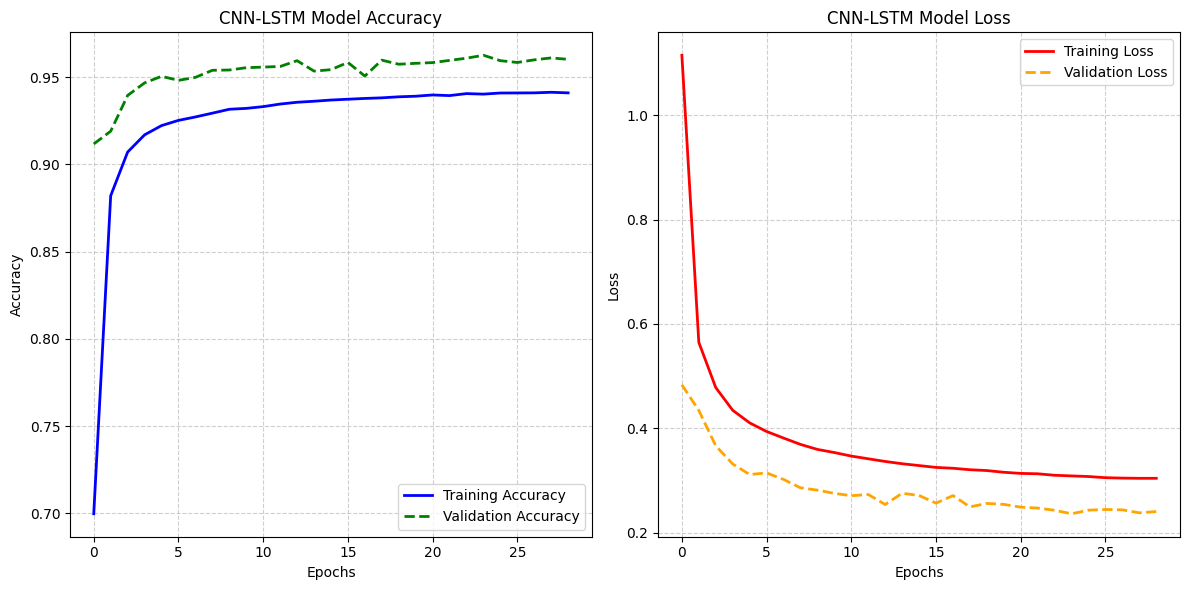

4720/4720 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step
CNN-LSTM Model Classification Report (Test Data):
              precision    recall  f1-score   support

           0       1.00      0.24      0.39      4494
           1       0.89      0.42      0.57      4489
           2       0.70      0.57      0.63      4481
           3       0.98      0.69      0.81      4527
           4       1.00      0.23      0.37      4359
           5       0.71      0.38      0.50      4191
           6       0.91      0.05      0.10      4501
           7       0.07      1.00      0.12      2705
           8       0.19      0.58      0.28      2979
           9       0.55      0.52      0.54      4446
          10       1.00      0.54      0.70      4404
          11       1.00      0.56      0.71      4350
          12       0.53      0.63      0.58      4542
          13       0.73      0.36      0.48     11037
          14       0.58      0.75      0.65      4527
          15       0.95      0.55      0.

In [24]:
import matplotlib.pyplot as plt
import tensorflow as tf
import json
import os
import numpy as np
import joblib
from sklearn.metrics import accuracy_score, classification_report

# Set base path for dataset
base_path = "/kaggle/input"  # Change to your dataset path

# Load test dataset
with open(os.path.join(base_path, "pjtii-dataset/test.json"), "r") as f:
    test_dl_data = json.load(f)

X_test_dl = np.array([entry["hand_landmarks"] for entry in test_dl_data])
y_test_dl = [entry["label"] for entry in test_dl_data]

# Load label encoder
label_encoder = joblib.load(os.path.join(base_path, "knn/tensorflow2/default/1/label_encoder.pkl"))
y_test_dl = label_encoder.transform(y_test_dl)
y_test_dl = tf.keras.utils.to_categorical(y_test_dl)

# Load trained CNN-LSTM model
model = tf.keras.models.load_model("/kaggle/working/cnn_lstm_2_model.keras")

# Evaluate model on test dataset
print("Evaluating CNN-LSTM model on test dataset...")
loss_test, accuracy_test = model.evaluate(X_test_dl, y_test_dl)
print(f"CNN-LSTM Model Test Accuracy: {accuracy_test * 100:.2f}%")
print(f"CNN-LSTM Model Test Loss: {loss_test:.4f}")

# Load training history
history_path = "/kaggle/working/cnn_lstm_2_training_history.json"
with open(history_path, "r") as f:
    history = json.load(f)

# Generate Accuracy & Loss Graphs
plt.figure(figsize=(12, 6))

# Accuracy Graph
plt.subplot(1, 2, 1)
plt.plot(history["accuracy"], label="Training Accuracy", color="blue", linewidth=2)
plt.plot(history["val_accuracy"], label="Validation Accuracy", color="green", linestyle="--", linewidth=2)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("CNN-LSTM Model Accuracy")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)

# Loss Graph
plt.subplot(1, 2, 2)
plt.plot(history["loss"], label="Training Loss", color="red", linewidth=2)
plt.plot(history["val_loss"], label="Validation Loss", color="orange", linestyle="--", linewidth=2)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("CNN-LSTM Model Loss")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()

# Get predictions
y_pred_dl_test = np.argmax(model.predict(X_test_dl), axis=1)
y_true_dl_test = np.argmax(y_test_dl, axis=1)

# Print classification report
print("CNN-LSTM Model Classification Report (Test Data):")
print(classification_report(y_true_dl_test, y_pred_dl_test))


In [4]:
import tensorflow as tf
import json
import os
import numpy as np
import joblib
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

base_path = "/kaggle/input" 

with open(os.path.join(base_path, "pjtii-dataset/hagrid_dl_dataset.json"), "r") as f:
    dl_data = json.load(f)

X_dl = np.array([entry["hand_landmarks"] for entry in dl_data])
y_dl = [entry["label"] for entry in dl_data]

label_encoder = joblib.load(os.path.join(base_path, "knn/tensorflow2/default/1/label_encoder.pkl"))
y_dl = label_encoder.transform(y_dl)
y_dl = tf.keras.utils.to_categorical(y_dl)

scaler = StandardScaler()
X_dl = scaler.fit_transform(X_dl.reshape(-1, X_dl.shape[-1])).reshape(X_dl.shape)

# Split dataset
X_train_dl, X_val_dl, y_train_dl, y_val_dl = train_test_split(X_dl, y_dl, test_size=0.2, random_state=42, stratify=y_dl)

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.1):
    x = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=head_size)(inputs, inputs)
    x = tf.keras.layers.Dropout(dropout)(x)
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    x = tf.keras.layers.Dense(ff_dim, activation="relu")(res)
    x = tf.keras.layers.Dropout(dropout)(x)
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res

inputs = tf.keras.layers.Input(shape=(X_train_dl.shape[1], X_train_dl.shape[2]))

x = tf.keras.layers.Conv1D(64, kernel_size=3, activation="relu")(inputs)
x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
x = tf.keras.layers.Conv1D(128, kernel_size=3, activation="relu")(x)

x = transformer_encoder(x, head_size=64, num_heads=4, ff_dim=128)

x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Dense(128, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(y_dl.shape[1], activation="softmax")(x)

model = tf.keras.models.Model(inputs, outputs)

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

history = model.fit(X_train_dl, y_train_dl,
                    validation_data=(X_val_dl, y_val_dl),
                    epochs=50,
                    batch_size=32,
                    callbacks=[early_stopping])

model.save("cnn_transformer_2_model.keras")

history_path = "cnn_transformer_2_training_history.json"
with open(history_path, "w") as f:
    json.dump(history.history, f)

print("Training complete. CNN-Transformer model and history saved successfully!")


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LabelEncoder from version 1.6.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Epoch 1/50
18581/18581 ━━━━━━━━━━━━━━━━━━━━ 62s 3ms/step - accuracy: 0.7544 - loss: 0.9643 - val_accuracy: 0.9518 - val_loss: 0.2176
Epoch 2/50
18581/18581 ━━━━━━━━━━━━━━━━━━━━ 51s 3ms/step - accuracy: 0.9484 - loss: 0.2299 - val_accuracy: 0.9571 - val_loss: 0.1914
Epoch 3/50
18581/18581 ━━━━━━━━━━━━━━━━━━━━ 52s 3ms/step - accuracy: 0.9544 - loss: 0.2027 - val_accuracy: 0.9546 - val_loss: 0.1909
Epoch 4/50
18581/18581 ━━━━━━━━━━━━━━━━━━━━ 51s 3ms/step - accuracy: 0.9577 - loss: 0.1882 - val_accuracy: 0.9639 - val_loss: 0.1659
Epoch 5/50
18581/18581 ━━━━━━━━━━━━━━━━━━━━ 51s 3ms/step - accuracy: 0.9598 - loss: 0.1786 - val_accuracy: 0.9602 - val_loss: 0.1772
Epoch 6/50
18581/18581 ━━━━━━━━━━━━━━━━━━━━ 51s 3ms/step - accuracy: 0.9616 - loss: 0.1723 - val_accuracy: 0.9636 - val_loss: 0.1608
Epoch 7/50
18581/18581 ━━━━━━━━━━━━━━━━━━━━ 51s 3ms/step - accuracy: 0.9625 - loss: 0.1671 - val_accuracy: 0.9650 - val_loss: 0.1607
Epoch 8/50
18581/18581 ━━━━━━━━━━━━━━━━━━━━ 51s 3ms/step - accuracy: 

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LabelEncoder from version 1.6.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Evaluating CNN-Transformer model on test dataset...
4720/4720 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.5656 - loss: 1.5441
CNN-Transformer Model Test Accuracy: 53.31%
CNN-Transformer Model Test Loss: 1.7116


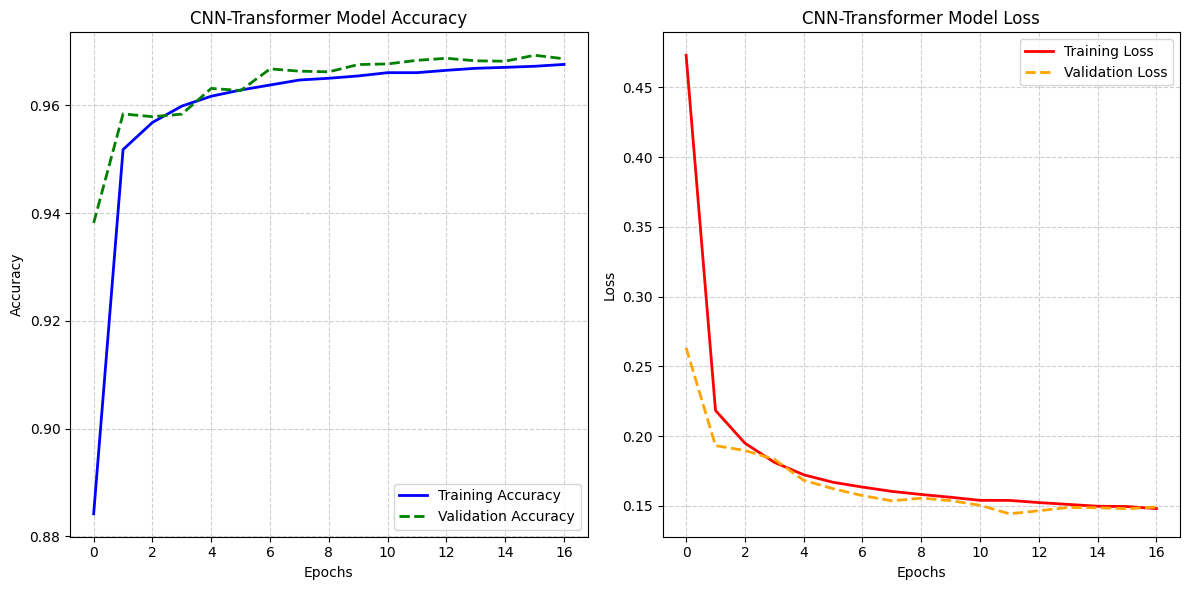

4720/4720 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
CNN-Transformer Model Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.95      0.79      0.87      4494
           1       0.89      0.52      0.66      4489
           2       0.83      0.83      0.83      4481
           3       0.77      0.75      0.76      4527
           4       1.00      0.25      0.40      4359
           5       0.97      0.15      0.25      4191
           6       0.78      0.18      0.29      4501
           7       0.07      1.00      0.12      2705
           8       0.25      0.60      0.35      2979
           9       0.95      0.59      0.73      4446
          10       0.99      0.77      0.87      4404
          11       1.00      0.52      0.68      4350
          12       0.54      0.78      0.63      4542
          13       0.98      0.10      0.18     11037
          14       0.47      0.92      0.62      4527
          15       0.76      0.65  

In [27]:
import matplotlib.pyplot as plt
import tensorflow as tf
import json
import os
import numpy as np
import joblib
from sklearn.metrics import accuracy_score, classification_report

# Set base path for dataset
base_path = "/kaggle/input"  # Change to your dataset path

# Load test dataset
with open(os.path.join(base_path, "pjtii-dataset/test.json"), "r") as f:
    test_dl_data = json.load(f)

X_test_dl = np.array([entry["hand_landmarks"] for entry in test_dl_data])
y_test_dl = [entry["label"] for entry in test_dl_data]

# Load label encoder
label_encoder = joblib.load(os.path.join(base_path, "knn/tensorflow2/default/1/label_encoder.pkl"))
y_test_dl = label_encoder.transform(y_test_dl)
y_test_dl = tf.keras.utils.to_categorical(y_test_dl)

# Load trained CNN-Transformer model
model = tf.keras.models.load_model("/kaggle/working/cnn_transformer_2_model.keras")

# Evaluate model on test dataset
print("Evaluating CNN-Transformer model on test dataset...")
loss_test, accuracy_test = model.evaluate(X_test_dl, y_test_dl)
print(f"CNN-Transformer Model Test Accuracy: {accuracy_test * 100:.2f}%")
print(f"CNN-Transformer Model Test Loss: {loss_test:.4f}")

# Load training history
history_path = "/kaggle/working/cnn_transformer_2_training_history.json"
with open(history_path, "r") as f:
    history = json.load(f)

# Generate Accuracy & Loss Graphs
plt.figure(figsize=(12, 6))

# Accuracy Graph
plt.subplot(1, 2, 1)
plt.plot(history["accuracy"], label="Training Accuracy", color="blue", linewidth=2)
plt.plot(history["val_accuracy"], label="Validation Accuracy", color="green", linestyle="--", linewidth=2)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("CNN-Transformer Model Accuracy")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)

# Loss Graph
plt.subplot(1, 2, 2)
plt.plot(history["loss"], label="Training Loss", color="red", linewidth=2)
plt.plot(history["val_loss"], label="Validation Loss", color="orange", linestyle="--", linewidth=2)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("CNN-Transformer Model Loss")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()

# Get predictions
y_pred_dl_test = np.argmax(model.predict(X_test_dl), axis=1)
y_true_dl_test = np.argmax(y_test_dl, axis=1)

# Print classification report
print("CNN-Transformer Model Classification Report (Test Data):")
print(classification_report(y_true_dl_test, y_pred_dl_test))


In [2]:
import tensorflow as tf
import json
import os
import numpy as np
import joblib
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Set base path for dataset
base_path = "/kaggle/input"  # Change to your dataset path

# Load dataset
with open(os.path.join(base_path, "pjtii-dataset/hagrid_dl_dataset.json"), "r") as f:
    dl_data = json.load(f)

X_dl = np.array([entry["hand_landmarks"] for entry in dl_data])
y_dl = [entry["label"] for entry in dl_data]

# Load label encoder
label_encoder = joblib.load(os.path.join(base_path, "knn/tensorflow2/default/1/label_encoder.pkl"))
y_dl = label_encoder.transform(y_dl)
y_dl = tf.keras.utils.to_categorical(y_dl)

# Normalize Data
scaler = StandardScaler()
X_dl = scaler.fit_transform(X_dl.reshape(-1, X_dl.shape[-1])).reshape(X_dl.shape)

# Split dataset
X_train_dl, X_val_dl, y_train_dl, y_val_dl = train_test_split(X_dl, y_dl, test_size=0.2, random_state=42, stratify=y_dl)

# Define Pure LSTM Model
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(128, return_sequences=True, input_shape=(X_train_dl.shape[1], X_train_dl.shape[2]), kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.3),  # Dropout to reduce overfitting
    tf.keras.layers.Dense(y_dl.shape[1], activation='softmax')
])

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Early Stopping Callback
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train_dl, y_train_dl,
                    validation_data=(X_val_dl, y_val_dl),
                    epochs=50,
                    batch_size=32,
                    callbacks=[early_stopping])

# Save model
model.save("lstm_2_model.keras")

# Save training history
history_path = "lstm_2_training_history.json"
with open(history_path, "w") as f:
    json.dump(history.history, f)

print("Training complete. LSTM model and history saved successfully!")


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LabelEncoder from version 1.6.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
18581/18581 ━━━━━━━━━━━━━━━━━━━━ 121s 6ms/step - accuracy: 0.6295 - loss: 1.3464 - val_accuracy: 0.9128 - val_loss: 0.3837
Epoch 2/50
18581/18581 ━━━━━━━━━━━━━━━━━━━━ 120s 6ms/step - accuracy: 0.9289 - loss: 0.3302 - val_accuracy: 0.9401 - val_loss: 0.2760
Epoch 3/50
18581/18581 ━━━━━━━━━━━━━━━━━━━━ 120s 6ms/step - accuracy: 0.9461 - loss: 0.2520 - val_accuracy: 0.9552 - val_loss: 0.2101
Epoch 4/50
18581/18581 ━━━━━━━━━━━━━━━━━━━━ 120s 6ms/step - accuracy: 0.9536 - loss: 0.2176 - val_accuracy: 0.9582 - val_loss: 0.1946
Epoch 5/50
18581/18581 ━━━━━━━━━━━━━━━━━━━━ 119s 6ms/step - accuracy: 0.9575 - loss: 0.1993 - val_accuracy: 0.9596 - val_loss: 0.1838
Epoch 6/50
18581/18581 ━━━━━━━━━━━━━━━━━━━━ 120s 6ms/step - accuracy: 0.9601 - loss: 0.1873 - val_accuracy: 0.9618 - val_loss: 0.1751
Epoch 7/50
18581/18581 ━━━━━━━━━━━━━━━━━━━━ 120s 6ms/step - accuracy: 0.9613 - loss: 0.1792 - val_accuracy: 0.9638 - val_loss: 0.1687
Epoch 8/50
18581/18581 ━━━━━━━━━━━━━━━━━━━━ 122s 7ms/step - ac

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LabelEncoder from version 1.6.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Evaluating LSTM model on test dataset...
4720/4720 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.5173 - loss: 1.8138
LSTM Model Test Accuracy: 51.33%
LSTM Model Test Loss: 1.8677


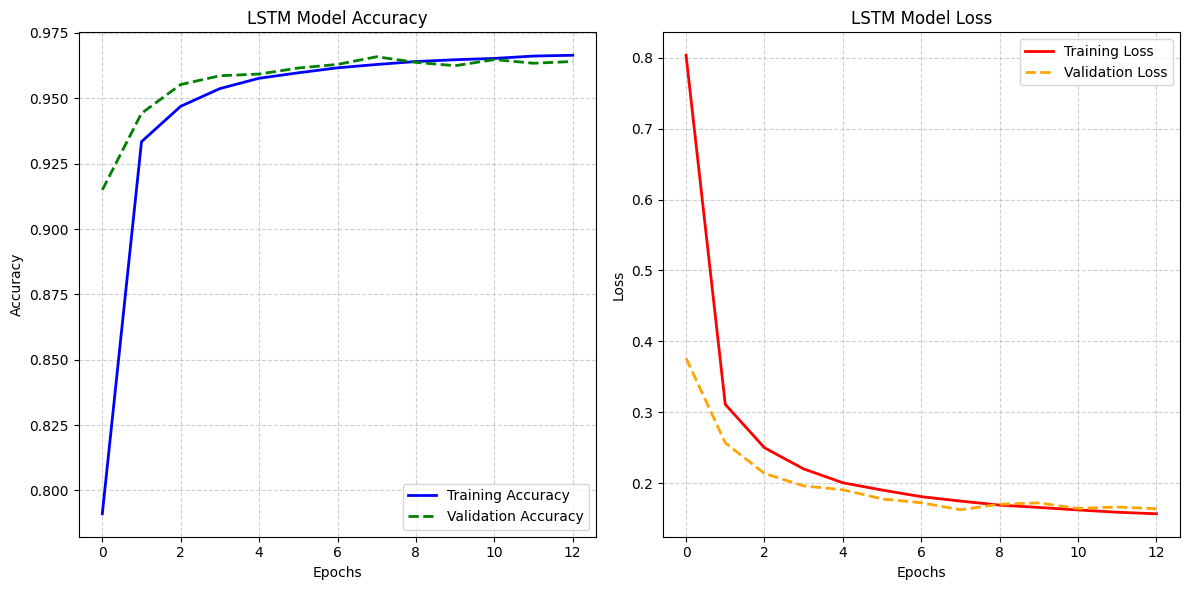

4720/4720 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step
LSTM Model Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.98      0.67      0.80      4494
           1       0.93      0.47      0.63      4489
           2       0.98      0.40      0.57      4481
           3       0.83      0.56      0.67      4527
           4       0.97      0.33      0.49      4359
           5       0.94      0.16      0.28      4191
           6       0.51      0.51      0.51      4501
           7       0.06      0.99      0.12      2705
           8       0.25      0.51      0.33      2979
           9       0.73      0.77      0.75      4446
          10       1.00      0.60      0.75      4404
          11       0.99      0.57      0.73      4350
          12       0.70      0.73      0.72      4542
          13       0.45      0.14      0.22     11037
          14       0.69      0.75      0.72      4527
          15       0.36      0.60      0.45  

In [29]:
import matplotlib.pyplot as plt
import tensorflow as tf
import json
import os
import numpy as np
import joblib
from sklearn.metrics import accuracy_score, classification_report

# Set base path for dataset
base_path = "/kaggle/input"  # Change to your dataset path

# Load test dataset
with open(os.path.join(base_path, "pjtii-dataset/test.json"), "r") as f:
    test_dl_data = json.load(f)

X_test_dl = np.array([entry["hand_landmarks"] for entry in test_dl_data])
y_test_dl = [entry["label"] for entry in test_dl_data]

# Load label encoder
label_encoder = joblib.load(os.path.join(base_path, "knn/tensorflow2/default/1/label_encoder.pkl"))
y_test_dl = label_encoder.transform(y_test_dl)
y_test_dl = tf.keras.utils.to_categorical(y_test_dl)

# Load trained LSTM model
model = tf.keras.models.load_model("/kaggle/working/lstm_2_model.keras")

# Evaluate model on test dataset
print("Evaluating LSTM model on test dataset...")
loss_test, accuracy_test = model.evaluate(X_test_dl, y_test_dl)
print(f"LSTM Model Test Accuracy: {accuracy_test * 100:.2f}%")
print(f"LSTM Model Test Loss: {loss_test:.4f}")

# Load training history
history_path = "/kaggle/working/lstm_2_training_history.json"
with open(history_path, "r") as f:
    history = json.load(f)

# Generate Accuracy & Loss Graphs
plt.figure(figsize=(12, 6))

# Accuracy Graph
plt.subplot(1, 2, 1)
plt.plot(history["accuracy"], label="Training Accuracy", color="blue", linewidth=2)
plt.plot(history["val_accuracy"], label="Validation Accuracy", color="green", linestyle="--", linewidth=2)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("LSTM Model Accuracy")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)

# Loss Graph
plt.subplot(1, 2, 2)
plt.plot(history["loss"], label="Training Loss", color="red", linewidth=2)
plt.plot(history["val_loss"], label="Validation Loss", color="orange", linestyle="--", linewidth=2)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("LSTM Model Loss")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()

# Get predictions
y_pred_dl_test = np.argmax(model.predict(X_test_dl), axis=1)
y_true_dl_test = np.argmax(y_test_dl, axis=1)

# Print classification report
print("LSTM Model Classification Report (Test Data):")
print(classification_report(y_true_dl_test, y_pred_dl_test))


In [9]:
import tensorflow as tf
import json
import os
import numpy as np
import joblib
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Set base path for dataset
base_path = "/kaggle/input"  # Change to your dataset path

# Load dataset
with open(os.path.join(base_path, "pjtii-dataset/hagrid_dl_dataset.json"), "r") as f:
    dl_data = json.load(f)

X_dl = np.array([entry["hand_landmarks"] for entry in dl_data])
y_dl = [entry["label"] for entry in dl_data]

# Load label encoder
label_encoder = joblib.load(os.path.join(base_path, "knn/tensorflow2/default/1/label_encoder.pkl"))
y_dl = label_encoder.transform(y_dl)
y_dl = tf.keras.utils.to_categorical(y_dl)

# Normalize Data
scaler = StandardScaler()
X_dl = scaler.fit_transform(X_dl.reshape(-1, X_dl.shape[-1])).reshape(X_dl.shape)

# Split dataset into training and test datasets
X_train_dl, X_test_dl, y_train_dl, y_test_dl = train_test_split(X_dl, y_dl, test_size=0.2, random_state=42, stratify=y_dl)

# Reshape data for 3D CNN (add depth dimension)
X_train_dl_reshaped = X_train_dl.reshape((X_train_dl.shape[0], X_train_dl.shape[1], X_train_dl.shape[2], 1, 1))  # (N, 21, 2, 1, 1)
X_test_dl_reshaped = X_test_dl.reshape((X_test_dl.shape[0], X_test_dl.shape[1], X_test_dl.shape[2], 1, 1))  # (N, 21, 2, 1, 1)

# Define 3D CNN Model
inputs = tf.keras.layers.Input(shape=(X_train_dl_reshaped.shape[1], X_train_dl_reshaped.shape[2], 1, 1))  # Adjusted input shape

# 3D Convolutional layers for feature extraction
x = tf.keras.layers.Conv3D(64, kernel_size=(2, 2, 2), activation="relu", padding="same")(inputs)  # Reduced kernel size and added padding
x = tf.keras.layers.MaxPooling3D(pool_size=(1, 1, 1))(x)  # Use smaller pooling size
x = tf.keras.layers.Conv3D(128, kernel_size=(2, 2, 2), activation="relu", padding="same")(x)  # Reduced kernel size and added padding
x = tf.keras.layers.MaxPooling3D(pool_size=(1, 1, 1))(x)  # Use smaller pooling size

# Flatten and Dense layers for classification
x = tf.keras.layers.GlobalAveragePooling3D()(x)  # Global pooling to reduce the 3D output
x = tf.keras.layers.Dense(128, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(y_dl.shape[1], activation="softmax")(x)

# Create model
model = tf.keras.models.Model(inputs, outputs)

# Compile model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Early stopping callback
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train_dl_reshaped, y_train_dl,
                    validation_data=(X_test_dl_reshaped, y_test_dl),
                    epochs=50,
                    batch_size=32,
                    callbacks=[early_stopping])

# Save model
model.save("3d_cnn_model.keras")

# Save training history
history_path = "3d_cnn_training_history.json"
with open(history_path, "w") as f:
    json.dump(history.history, f)

print("Training complete. 3D CNN model and history saved successfully!")


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LabelEncoder from version 1.6.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Epoch 1/50
18581/18581 ━━━━━━━━━━━━━━━━━━━━ 50s 2ms/step - accuracy: 0.1700 - loss: 2.9781 - val_accuracy: 0.5039 - val_loss: 1.7444
Epoch 2/50
18581/18581 ━━━━━━━━━━━━━━━━━━━━ 43s 2ms/step - accuracy: 0.5260 - loss: 1.6422 - val_accuracy: 0.6848 - val_loss: 1.1506
Epoch 3/50
18581/18581 ━━━━━━━━━━━━━━━━━━━━ 43s 2ms/step - accuracy: 0.6550 - loss: 1.2111 - val_accuracy: 0.7341 - val_loss: 0.9757
Epoch 4/50
18581/18581 ━━━━━━━━━━━━━━━━━━━━ 43s 2ms/step - accuracy: 0.6980 - loss: 1.0677 - val_accuracy: 0.7731 - val_loss: 0.8560
Epoch 5/50
18581/18581 ━━━━━━━━━━━━━━━━━━━━ 43s 2ms/step - accuracy: 0.7226 - loss: 0.9833 - val_accuracy: 0.7895 - val_loss: 0.7807
Epoch 6/50
18581/18581 ━━━━━━━━━━━━━━━━━━━━ 43s 2ms/step - accuracy: 0.7433 - loss: 0.9186 - val_accuracy: 0.8087 - val_loss: 0.7216
Epoch 7/50
18581/18581 ━━━━━━━━━━━━━━━━━━━━ 43s 2ms/step - accuracy: 0.7578 - loss: 0.8726 - val_accuracy: 0.8204 - val_loss: 0.7015
Epoch 8/50
18581/18581 ━━━━━━━━━━━━━━━━━━━━ 43s 2ms/step - accuracy: 

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LabelEncoder from version 1.6.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


944/944 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Inference Time: 2.5642 seconds

Top Misclassified Classes and their Misclassification Rates:
   Class  Misclassification Rate  Total Misclassified
0     29                0.643013                  589
1     30                0.128310                   63
2     23                0.061911                   46
3     13                0.019475                   43
4     15                0.040223                   36


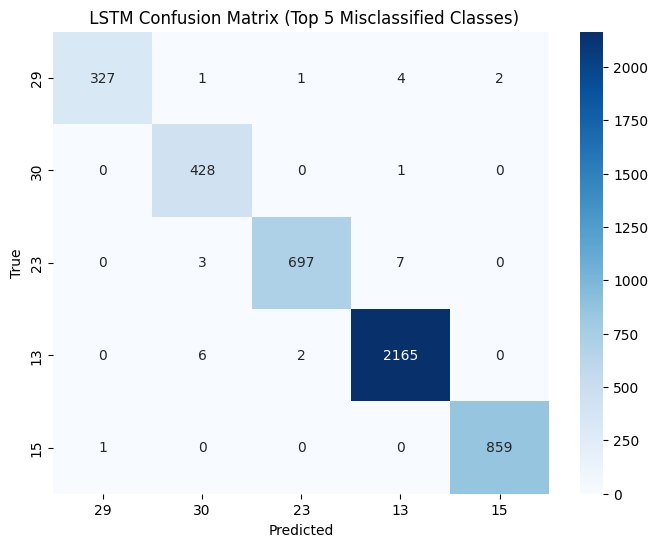

Accuracy: 0.9620
Precision: 0.9675
Recall: 0.9620
F1-Score: 0.9597
Evaluation complete. Results saved successfully!


In [17]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import time
import seaborn as sns
import matplotlib.pyplot as plt
import json
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd

# Set base path for dataset
base_path = "/kaggle/input"  # Change to your dataset path

# Load dataset
with open(os.path.join(base_path, "pjtii-dataset/test.json"), "r") as f:
    dl_data = json.load(f)

X_dl = np.array([entry["hand_landmarks"] for entry in dl_data])
y_dl = [entry["label"] for entry in dl_data]

# Load label encoder
label_encoder = joblib.load(os.path.join(base_path, "knn/tensorflow2/default/1/label_encoder.pkl"))
y_dl = label_encoder.transform(y_dl)
y_dl = tf.keras.utils.to_categorical(y_dl)

# Normalize Data
scaler = StandardScaler()
X_dl = scaler.fit_transform(X_dl.reshape(-1, X_dl.shape[-1])).reshape(X_dl.shape)

# Split dataset into training and test datasets
X_train_dl, X_test_dl, y_train_dl, y_test_dl = train_test_split(X_dl, y_dl, test_size=0.2, random_state=42, stratify=y_dl)

# Reshape data for LSTM (reshape as 2D for LSTM)
X_train_dl_reshaped = X_train_dl.reshape((X_train_dl.shape[0], X_train_dl.shape[1], X_train_dl.shape[2]))  # (N, 21, 2)
X_test_dl_reshaped = X_test_dl.reshape((X_test_dl.shape[0], X_test_dl.shape[1], X_test_dl.shape[2]))  # (N, 21, 2)

# Load the trained LSTM Model
model = tf.keras.models.load_model("/kaggle/working/lstm_2_model.keras")

# Evaluate the model
def evaluate_model(model, X_test, y_test, top_n=5):
    # Start measuring inference time
    start_time = time.time()
    
    # Predict the test dataset
    y_pred = np.argmax(model.predict(X_test, batch_size=32), axis=1)
    
    # Calculate inference time
    inference_time = time.time() - start_time
    print(f"Inference Time: {inference_time:.4f} seconds")
    
    # Calculate metrics
    accuracy = accuracy_score(np.argmax(y_test, axis=1), y_pred)
    precision = precision_score(np.argmax(y_test, axis=1), y_pred, average='weighted')
    recall = recall_score(np.argmax(y_test, axis=1), y_pred, average='weighted')
    f1 = f1_score(np.argmax(y_test, axis=1), y_pred, average='weighted')
    
    # Confusion Matrix
    cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    
    # Calculate misclassification rate for each class
    misclassifications = np.sum(cm, axis=1) - np.diagonal(cm)
    misclassification_rate = misclassifications / np.sum(cm, axis=1)
    
    # Get the top N classes with the most errors
    top_misclassified_classes = np.argsort(misclassifications)[::-1][:top_n]
    
    # Prepare a DataFrame with misclassification rates for the top N classes
    misclassification_df = pd.DataFrame({
        'Class': top_misclassified_classes,
        'Misclassification Rate': misclassification_rate[top_misclassified_classes],
        'Total Misclassified': misclassifications[top_misclassified_classes]
    })
    
    # Display the table of top N misclassified classes
    print("\nTop Misclassified Classes and their Misclassification Rates:")
    print(misclassification_df)
    
    # Filter the confusion matrix to show only the top misclassified classes
    cm_filtered = cm[top_misclassified_classes, :][:, top_misclassified_classes]
    
    # Plot the filtered confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_filtered, annot=True, fmt="d", cmap="Blues", 
                xticklabels=top_misclassified_classes, yticklabels=top_misclassified_classes)
    plt.title(f" LSTM Confusion Matrix (Top {top_n} Misclassified Classes)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()
    
    # Display results
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    
    return accuracy, precision, recall, f1, cm, inference_time

# Run evaluation on the test dataset (focus on top 5 misclassified classes)
accuracy, precision, recall, f1, cm, inference_time = evaluate_model(model, X_test_dl_reshaped, y_test_dl, top_n=5)

# Save evaluation results to JSON
eval_results = {
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1_score": f1,
    "inference_time": inference_time,
    "confusion_matrix": cm.tolist()  # Convert numpy array to list for saving in JSON
}

# Save the results to a file
with open("evaluation_results_lstm.json", "w") as f:
    json.dump(eval_results, f)

print("Evaluation complete. Results saved successfully!")


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LabelEncoder from version 1.6.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


944/944 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Inference Time: 2.7021 seconds

Top Misclassified Classes and their Misclassification Rates:
   Class  Misclassification Rate  Total Misclassified
0     29                0.567686                  520
1     30                0.164969                   81
2     28                0.074890                   68
3     23                0.074024                   55
4      8                0.073826                   44


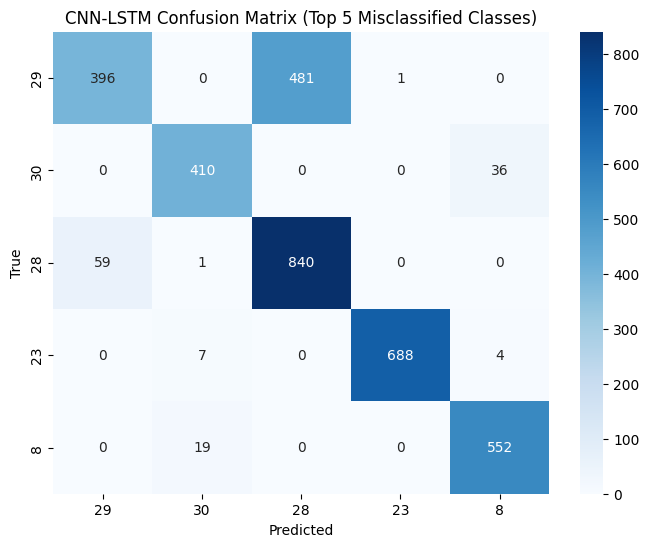

Accuracy: 0.9566
Precision: 0.9599
Recall: 0.9566
F1-Score: 0.9551
Evaluation complete. Results saved successfully!


In [15]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import time
import seaborn as sns
import matplotlib.pyplot as plt
import json
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd

# Set base path for dataset
base_path = "/kaggle/input"  # Change to your dataset path

# Load dataset
with open(os.path.join(base_path, "pjtii-dataset/test.json"), "r") as f:
    dl_data = json.load(f)

X_dl = np.array([entry["hand_landmarks"] for entry in dl_data])
y_dl = [entry["label"] for entry in dl_data]

# Load label encoder
label_encoder = joblib.load(os.path.join(base_path, "knn/tensorflow2/default/1/label_encoder.pkl"))
y_dl = label_encoder.transform(y_dl)
y_dl = tf.keras.utils.to_categorical(y_dl)

# Normalize Data
scaler = StandardScaler()
X_dl = scaler.fit_transform(X_dl.reshape(-1, X_dl.shape[-1])).reshape(X_dl.shape)

# Split dataset into training and test datasets
X_train_dl, X_test_dl, y_train_dl, y_test_dl = train_test_split(X_dl, y_dl, test_size=0.2, random_state=42, stratify=y_dl)

# Reshape data for CNN-LSTM Hybrid Model (reshape as 3D for LSTM)
X_train_dl_reshaped = X_train_dl.reshape((X_train_dl.shape[0], X_train_dl.shape[1], X_train_dl.shape[2], 1))  # (N, 21, 2, 1)
X_test_dl_reshaped = X_test_dl.reshape((X_test_dl.shape[0], X_test_dl.shape[1], X_test_dl.shape[2], 1))  # (N, 21, 2, 1)

# Load the trained CNN-LSTM Hybrid Model
model = tf.keras.models.load_model("/kaggle/working/cnn_lstm_2_model.keras")

# Evaluate the model
def evaluate_model(model, X_test, y_test, top_n=5):
    # Start measuring inference time
    start_time = time.time()
    
    # Predict the test dataset
    y_pred = np.argmax(model.predict(X_test, batch_size=32), axis=1)
    
    # Calculate inference time
    inference_time = time.time() - start_time
    print(f"Inference Time: {inference_time:.4f} seconds")
    
    # Calculate metrics
    accuracy = accuracy_score(np.argmax(y_test, axis=1), y_pred)
    precision = precision_score(np.argmax(y_test, axis=1), y_pred, average='weighted')
    recall = recall_score(np.argmax(y_test, axis=1), y_pred, average='weighted')
    f1 = f1_score(np.argmax(y_test, axis=1), y_pred, average='weighted')
    
    # Confusion Matrix
    cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    
    # Calculate misclassification rate for each class
    misclassifications = np.sum(cm, axis=1) - np.diagonal(cm)
    misclassification_rate = misclassifications / np.sum(cm, axis=1)
    
    # Get the top N classes with the most errors
    top_misclassified_classes = np.argsort(misclassifications)[::-1][:top_n]
    
    # Prepare a DataFrame with misclassification rates for the top N classes
    misclassification_df = pd.DataFrame({
        'Class': top_misclassified_classes,
        'Misclassification Rate': misclassification_rate[top_misclassified_classes],
        'Total Misclassified': misclassifications[top_misclassified_classes]
    })
    
    # Display the table of top N misclassified classes
    print("\nTop Misclassified Classes and their Misclassification Rates:")
    print(misclassification_df)
    
    # Filter the confusion matrix to show only the top misclassified classes
    cm_filtered = cm[top_misclassified_classes, :][:, top_misclassified_classes]
    
    # Plot the filtered confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_filtered, annot=True, fmt="d", cmap="Blues", 
                xticklabels=top_misclassified_classes, yticklabels=top_misclassified_classes)
    plt.title(f"CNN-LSTM Confusion Matrix (Top {top_n} Misclassified Classes)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()
    
    # Display results
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    
    return accuracy, precision, recall, f1, cm, inference_time

# Run evaluation on the test dataset (focus on top 5 misclassified classes)
accuracy, precision, recall, f1, cm, inference_time = evaluate_model(model, X_test_dl_reshaped, y_test_dl, top_n=5)

# Save evaluation results to JSON
eval_results = {
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1_score": f1,
    "inference_time": inference_time,
    "confusion_matrix": cm.tolist()  # Convert numpy array to list for saving in JSON
}

# Save the results to a file
with open("evaluation_results_cnn_lstm_hybrid.json", "w") as f:
    json.dump(eval_results, f)

print("Evaluation complete. Results saved successfully!")


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LabelEncoder from version 1.6.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


944/944 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Inference Time: 2.2856 seconds

Top Misclassified Classes and their Misclassification Rates:
   Class  Misclassification Rate  Total Misclassified
0     29                0.671397                  615
1     23                0.150740                  112
2     30                0.224033                  110
3     13                0.049819                  110
4     18                0.116228                  106


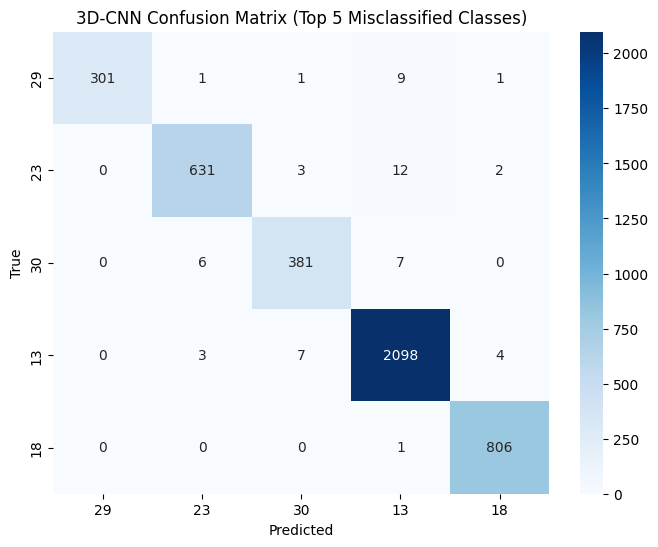

Accuracy: 0.9238
Precision: 0.9284
Recall: 0.9238
F1-Score: 0.9212
Evaluation complete. Results saved successfully!


In [18]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import time
import seaborn as sns
import matplotlib.pyplot as plt
import json
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd

# Set base path for dataset
base_path = "/kaggle/input"  # Change to your dataset path

# Load dataset
with open(os.path.join(base_path, "pjtii-dataset/test.json"), "r") as f:
    dl_data = json.load(f)

X_dl = np.array([entry["hand_landmarks"] for entry in dl_data])
y_dl = [entry["label"] for entry in dl_data]

# Load label encoder
label_encoder = joblib.load(os.path.join(base_path, "knn/tensorflow2/default/1/label_encoder.pkl"))
y_dl = label_encoder.transform(y_dl)
y_dl = tf.keras.utils.to_categorical(y_dl)

# Normalize Data
scaler = StandardScaler()
X_dl = scaler.fit_transform(X_dl.reshape(-1, X_dl.shape[-1])).reshape(X_dl.shape)

# Split dataset into training and test datasets
X_train_dl, X_test_dl, y_train_dl, y_test_dl = train_test_split(X_dl, y_dl, test_size=0.2, random_state=42, stratify=y_dl)

# Reshape data for 3D CNN Model (add depth dimension)
X_train_dl_reshaped = X_train_dl.reshape((X_train_dl.shape[0], X_train_dl.shape[1], X_train_dl.shape[2], 1, 1))  # (N, 21, 2, 1, 1)
X_test_dl_reshaped = X_test_dl.reshape((X_test_dl.shape[0], X_test_dl.shape[1], X_test_dl.shape[2], 1, 1))  # (N, 21, 2, 1, 1)

# Load the trained 3D CNN Model
model = tf.keras.models.load_model("/kaggle/working/3d_cnn_model.keras")

# Evaluate the model
def evaluate_model(model, X_test, y_test, top_n=5):
    # Start measuring inference time
    start_time = time.time()
    
    # Predict the test dataset
    y_pred = np.argmax(model.predict(X_test, batch_size=32), axis=1)
    
    # Calculate inference time
    inference_time = time.time() - start_time
    print(f"Inference Time: {inference_time:.4f} seconds")
    
    # Calculate metrics
    accuracy = accuracy_score(np.argmax(y_test, axis=1), y_pred)
    precision = precision_score(np.argmax(y_test, axis=1), y_pred, average='weighted')
    recall = recall_score(np.argmax(y_test, axis=1), y_pred, average='weighted')
    f1 = f1_score(np.argmax(y_test, axis=1), y_pred, average='weighted')
    
    # Confusion Matrix
    cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    
    # Calculate misclassification rate for each class
    misclassifications = np.sum(cm, axis=1) - np.diagonal(cm)
    misclassification_rate = misclassifications / np.sum(cm, axis=1)
    
    # Get the top N classes with the most errors
    top_misclassified_classes = np.argsort(misclassifications)[::-1][:top_n]
    
    # Prepare a DataFrame with misclassification rates for the top N classes
    misclassification_df = pd.DataFrame({
        'Class': top_misclassified_classes,
        'Misclassification Rate': misclassification_rate[top_misclassified_classes],
        'Total Misclassified': misclassifications[top_misclassified_classes]
    })
    
    # Display the table of top N misclassified classes
    print("\nTop Misclassified Classes and their Misclassification Rates:")
    print(misclassification_df)
    
    # Filter the confusion matrix to show only the top misclassified classes
    cm_filtered = cm[top_misclassified_classes, :][:, top_misclassified_classes]
    
    # Plot the filtered confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_filtered, annot=True, fmt="d", cmap="Blues", 
                xticklabels=top_misclassified_classes, yticklabels=top_misclassified_classes)
    plt.title(f"3D-CNN Confusion Matrix (Top {top_n} Misclassified Classes)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()
    
    # Display results
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    
    return accuracy, precision, recall, f1, cm, inference_time

# Run evaluation on the test dataset (focus on top 5 misclassified classes)
accuracy, precision, recall, f1, cm, inference_time = evaluate_model(model, X_test_dl_reshaped, y_test_dl, top_n=5)

# Save evaluation results to JSON
eval_results = {
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1_score": f1,
    "inference_time": inference_time,
    "confusion_matrix": cm.tolist()  # Convert numpy array to list for saving in JSON
}

# Save the results to a file
with open("evaluation_results_3d_cnn.json", "w") as f:
    json.dump(eval_results, f)

print("Evaluation complete. Results saved successfully!")


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LabelEncoder from version 1.6.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Epoch 1/50
18581/18581 ━━━━━━━━━━━━━━━━━━━━ 211s 10ms/step - accuracy: 0.5069 - loss: 1.6332 - val_accuracy: 0.8627 - val_loss: 0.4916
Epoch 2/50
18581/18581 ━━━━━━━━━━━━━━━━━━━━ 176s 9ms/step - accuracy: 0.8478 - loss: 0.5288 - val_accuracy: 0.8076 - val_loss: 0.6466
Epoch 3/50
18581/18581 ━━━━━━━━━━━━━━━━━━━━ 176s 9ms/step - accuracy: 0.8658 - loss: 0.4762 - val_accuracy: 0.8796 - val_loss: 0.4319
Epoch 4/50
18581/18581 ━━━━━━━━━━━━━━━━━━━━ 173s 9ms/step - accuracy: 0.8735 - loss: 0.4512 - val_accuracy: 0.8960 - val_loss: 0.3764
Epoch 5/50
18581/18581 ━━━━━━━━━━━━━━━━━━━━ 177s 10ms/step - accuracy: 0.8892 - loss: 0.3938 - val_accuracy: 0.8857 - val_loss: 0.4118
Epoch 6/50
18581/18581 ━━━━━━━━━━━━━━━━━━━━ 176s 9ms/step - accuracy: 0.8344 - loss: 0.5763 - val_accuracy: 0.8702 - val_loss: 0.4592
Epoch 7/50
18581/18581 ━━━━━━━━━━━━━━━━━━━━ 177s 10ms/step - accuracy: 0.8676 - loss: 0.4614 - val_accuracy: 0.8541 - val_loss: 0.5052
Epoch 8/50
18581/18581 ━━━━━━━━━━━━━━━━━━━━ 176s 9ms/step -

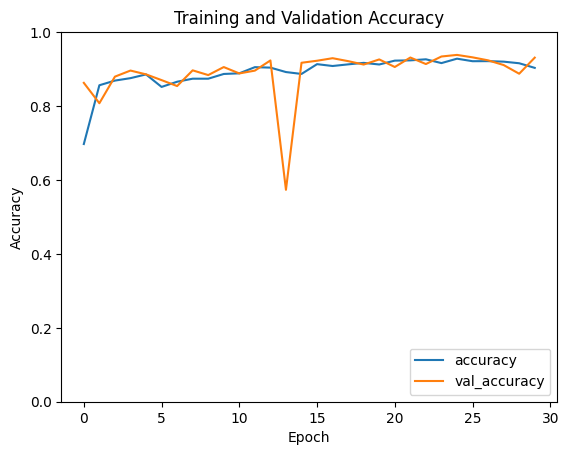

Training complete. Vision Transformer model and history saved successfully!


In [20]:
import tensorflow as tf
import numpy as np
import json
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Set base path for dataset
base_path = "/kaggle/input"  # Change to your dataset path

# Load dataset
with open(os.path.join(base_path, "pjtii-dataset/hagrid_dl_dataset.json"), "r") as f:
    dl_data = json.load(f)

X_dl = np.array([entry["hand_landmarks"] for entry in dl_data])
y_dl = [entry["label"] for entry in dl_data]

# Load label encoder
label_encoder = joblib.load(os.path.join(base_path, "knn/tensorflow2/default/1/label_encoder.pkl"))
y_dl = label_encoder.transform(y_dl)
y_dl = tf.keras.utils.to_categorical(y_dl)

# Normalize Data
scaler = StandardScaler()
X_dl = scaler.fit_transform(X_dl.reshape(-1, X_dl.shape[-1])).reshape(X_dl.shape)

# Split dataset into training and test datasets
X_train_dl, X_test_dl, y_train_dl, y_test_dl = train_test_split(X_dl, y_dl, test_size=0.2, random_state=42, stratify=y_dl)

# Reshape data for Vision Transformer (ViT)
# ViT expects image-like data, so we treat 21 landmarks as 21 patches.
# We reshape the data to (N, patches, patch_size) - (samples, 21, 2) treated as (samples, patches, patch_size)
X_train_dl_reshaped = X_train_dl.reshape((X_train_dl.shape[0], X_train_dl.shape[1], X_train_dl.shape[2]))
X_test_dl_reshaped = X_test_dl.reshape((X_test_dl.shape[0], X_test_dl.shape[1], X_test_dl.shape[2]))

# Define Vision Transformer model (ViT)

def create_vit_model(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)

    # Patch Embedding: Flatten each patch and embed them using a linear layer
    x = tf.keras.layers.Reshape((input_shape[0], input_shape[1]))(inputs)  # Reshaping for patches
    x = tf.keras.layers.Dense(128)(x)  # Patch Embedding
    
    # Add positional encoding to patches (for order)
    pos_emb = tf.keras.layers.Embedding(input_dim=input_shape[0], output_dim=128)(tf.range(input_shape[0]))
    x = x + pos_emb  # Adding positional encoding

    # Encoder blocks (multi-head self-attention, feed-forward)
    for _ in range(6):  # 6 Transformer Encoder layers
        # Multi-Head Self-Attention Layer
        attention_output = tf.keras.layers.MultiHeadAttention(num_heads=4, key_dim=128)(x, x)
        x = tf.keras.layers.LayerNormalization()(x + attention_output)  # Residual Connection
        
        # Feed Forward Layer (adjusted output dimension)
        ff_output = tf.keras.layers.Dense(128, activation='relu')(x)  # Changed to 128 to match attention output
        x = tf.keras.layers.LayerNormalization()(x + ff_output)  # Residual Connection

    # Pooling (Global Average Pooling)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)

    # Output Layer
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

# Create the Vision Transformer model
input_shape = (X_train_dl_reshaped.shape[1], X_train_dl_reshaped.shape[2])
num_classes = y_dl.shape[1]  # Number of gesture classes
vit_model = create_vit_model(input_shape, num_classes)

# Compile the model
vit_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Set EarlyStopping callback
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

# Train the model
history = vit_model.fit(X_train_dl_reshaped, y_train_dl,
                        validation_data=(X_test_dl_reshaped, y_test_dl),
                        epochs=50,
                        batch_size=32,
                        callbacks=[early_stopping])

# Save the trained model
vit_model.save("vit_model.keras")

# Save training history
history_path = "vit_training_history.json"
with open(history_path, "w") as f:
    json.dump(history.history, f)

# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

print("Training complete. Vision Transformer model and history saved successfully!")


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LabelEncoder from version 1.6.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


944/944 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step
Inference Time: 8.2201 seconds

Top Misclassified Classes and their Misclassification Rates:
   Class  Misclassification Rate  Total Misclassified
0     29                0.670306                  614
1     28                0.138767                  126
2     30                0.228106                  112
3     13                0.047101                  104
4      6                0.098889                   89


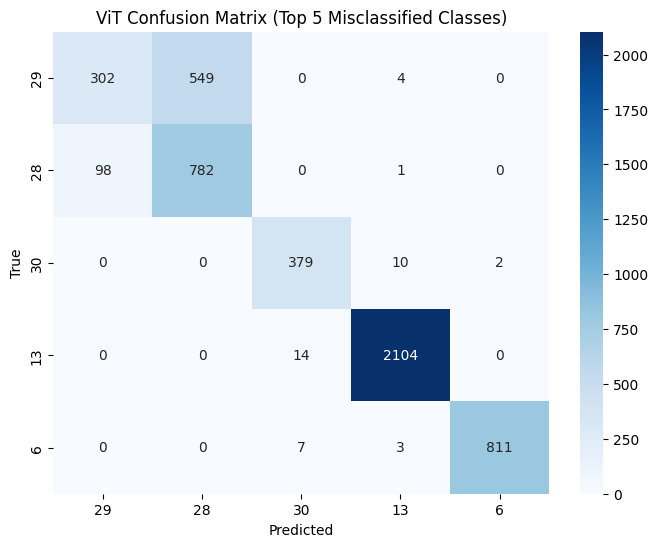

Accuracy: 0.9320
Precision: 0.9343
Recall: 0.9320
F1-Score: 0.9296
Evaluation complete. Results saved successfully!


In [24]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import time
import seaborn as sns
import matplotlib.pyplot as plt
import json
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd

base_path = "/kaggle/input"  # Change to your dataset path

with open(os.path.join(base_path, "pjtii-dataset/test.json"), "r") as f:
    dl_data = json.load(f)

X_dl = np.array([entry["hand_landmarks"] for entry in dl_data])
y_dl = [entry["label"] for entry in dl_data]

label_encoder = joblib.load(os.path.join(base_path, "knn/tensorflow2/default/1/label_encoder.pkl"))
y_dl = label_encoder.transform(y_dl)
y_dl = tf.keras.utils.to_categorical(y_dl)

scaler = StandardScaler()
X_dl = scaler.fit_transform(X_dl.reshape(-1, X_dl.shape[-1])).reshape(X_dl.shape)

X_train_dl, X_test_dl, y_train_dl, y_test_dl = train_test_split(X_dl, y_dl, test_size=0.2, random_state=42, stratify=y_dl)

X_train_dl_reshaped = X_train_dl.reshape((X_train_dl.shape[0], X_train_dl.shape[1], X_train_dl.shape[2]))
X_test_dl_reshaped = X_test_dl.reshape((X_test_dl.shape[0], X_test_dl.shape[1], X_test_dl.shape[2]))

vit_model = tf.keras.models.load_model("/kaggle/working/vit_model.keras")

def evaluate_model(model, X_test, y_test, top_n=5):
    start_time = time.time()
    
    y_pred = np.argmax(model.predict(X_test, batch_size=32), axis=1)
    
    inference_time = time.time() - start_time
    print(f"Inference Time: {inference_time:.4f} seconds")
    
    accuracy = accuracy_score(np.argmax(y_test, axis=1), y_pred)
    precision = precision_score(np.argmax(y_test, axis=1), y_pred, average='weighted')
    recall = recall_score(np.argmax(y_test, axis=1), y_pred, average='weighted')
    f1 = f1_score(np.argmax(y_test, axis=1), y_pred, average='weighted')
    
    cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    
    misclassifications = np.sum(cm, axis=1) - np.diagonal(cm)
    misclassification_rate = misclassifications / np.sum(cm, axis=1)
    
    top_misclassified_classes = np.argsort(misclassifications)[::-1][:top_n]
    
    misclassification_df = pd.DataFrame({
        'Class': top_misclassified_classes,
        'Misclassification Rate': misclassification_rate[top_misclassified_classes],
        'Total Misclassified': misclassifications[top_misclassified_classes]
    })
    
    print("\nTop Misclassified Classes and their Misclassification Rates:")
    print(misclassification_df)
    
    cm_filtered = cm[top_misclassified_classes, :][:, top_misclassified_classes]
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_filtered, annot=True, fmt="d", cmap="Blues", 
                xticklabels=top_misclassified_classes, yticklabels=top_misclassified_classes)
    plt.title(f"ViT Confusion Matrix (Top {top_n} Misclassified Classes)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    
    return accuracy, precision, recall, f1, cm, inference_time

accuracy, precision, recall, f1, cm, inference_time = evaluate_model(vit_model, X_test_dl_reshaped, y_test_dl, top_n=5)

eval_results = {
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1_score": f1,
    "inference_time": inference_time,
    "confusion_matrix": cm.tolist()  

with open("evaluation_results_vit.json", "w") as f:
    json.dump(eval_results, f)

print("Evaluation complete. Results saved successfully!")


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LabelEncoder from version 1.6.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


944/944 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
Inference Time: 3.6048 seconds

Top Misclassified Classes and their Misclassification Rates:
   Class  Misclassification Rate  Total Misclassified
0     29                0.502183                  460
1     30                0.179226                   88
2     28                0.089207                   81
3     13                0.027174                   60
4     23                0.059219                   44


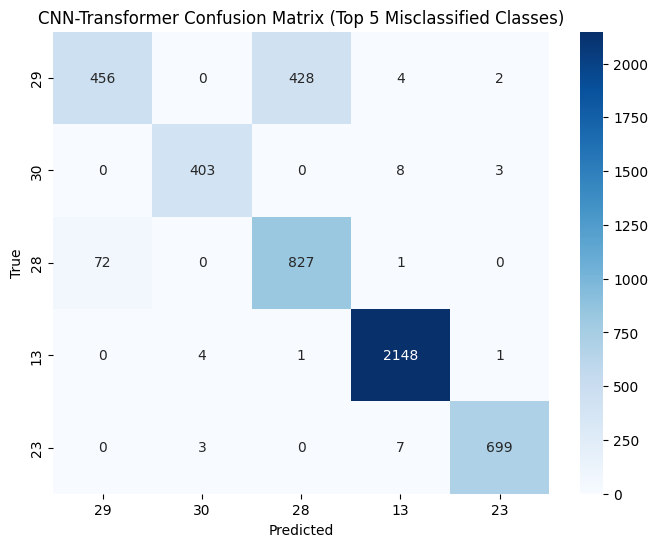

Accuracy: 0.9634
Precision: 0.9660
Recall: 0.9634
F1-Score: 0.9624
Evaluation complete. Results saved successfully!


In [26]:
import os
import tensorflow as tf
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import time
import seaborn as sns
import matplotlib.pyplot as plt
import json
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd

# Set base path for dataset
base_path = "/kaggle/input"  # Change to your dataset path

# Load dataset
with open(os.path.join(base_path, "pjtii-dataset/test.json"), "r") as f:
    dl_data = json.load(f)

X_dl = np.array([entry["hand_landmarks"] for entry in dl_data])
y_dl = [entry["label"] for entry in dl_data]

# Load label encoder
label_encoder = joblib.load(os.path.join(base_path, "knn/tensorflow2/default/1/label_encoder.pkl"))
y_dl = label_encoder.transform(y_dl)
y_dl = tf.keras.utils.to_categorical(y_dl)

# Normalize Data
scaler = StandardScaler()
X_dl = scaler.fit_transform(X_dl.reshape(-1, X_dl.shape[-1])).reshape(X_dl.shape)

# Split dataset into training and test datasets
X_train_dl, X_test_dl, y_train_dl, y_test_dl = train_test_split(X_dl, y_dl, test_size=0.2, random_state=42, stratify=y_dl)

# Reshape data for CNN-Transformer Model (remove depth dimension)
X_train_dl_reshaped = X_train_dl.reshape((X_train_dl.shape[0], X_train_dl.shape[1], X_train_dl.shape[2]))  # (N, 21, 2)
X_test_dl_reshaped = X_test_dl.reshape((X_test_dl.shape[0], X_test_dl.shape[1], X_test_dl.shape[2]))  # (N, 21, 2)

# Load the trained CNN-Transformer Model
model = tf.keras.models.load_model("/kaggle/input/cnn-transformer/keras/default/1/cnn_transformer_2_model.keras")

def evaluate_model(model, X_test, y_test, top_n=5):
    start_time = time.time()
    
    y_pred = np.argmax(model.predict(X_test, batch_size=32), axis=1)
    
    inference_time = time.time() - start_time
    print(f"Inference Time: {inference_time:.4f} seconds")
    
    accuracy = accuracy_score(np.argmax(y_test, axis=1), y_pred)
    precision = precision_score(np.argmax(y_test, axis=1), y_pred, average='weighted')
    recall = recall_score(np.argmax(y_test, axis=1), y_pred, average='weighted')
    f1 = f1_score(np.argmax(y_test, axis=1), y_pred, average='weighted')
    
    cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    
    misclassifications = np.sum(cm, axis=1) - np.diagonal(cm)
    misclassification_rate = misclassifications / np.sum(cm, axis=1)
    
    top_misclassified_classes = np.argsort(misclassifications)[::-1][:top_n]
    
    misclassification_df = pd.DataFrame({
        'Class': top_misclassified_classes,
        'Misclassification Rate': misclassification_rate[top_misclassified_classes],
        'Total Misclassified': misclassifications[top_misclassified_classes]
    })
    
    print("\nTop Misclassified Classes and their Misclassification Rates:")
    print(misclassification_df)
    
    cm_filtered = cm[top_misclassified_classes, :][:, top_misclassified_classes]
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_filtered, annot=True, fmt="d", cmap="Blues", 
                xticklabels=top_misclassified_classes, yticklabels=top_misclassified_classes)
    plt.title(f"CNN-Transformer Confusion Matrix (Top {top_n} Misclassified Classes)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    
    return accuracy, precision, recall, f1, cm, inference_time

accuracy, precision, recall, f1, cm, inference_time = evaluate_model(model, X_test_dl_reshaped, y_test_dl, top_n=5)

eval_results = {
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1_score": f1,
    "inference_time": inference_time,
    "confusion_matrix": cm.tolist()  
}

with open("evaluation_results_cnn_transformer.json", "w") as f:
    json.dump(eval_results, f)

print("Evaluation complete. Results saved successfully!")
